# Processing Sequences using RNNs and CNNs

Understanding the fundamentals of RNNs and using them to forecast a time series.

## Setup

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os
from pathlib import Path

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

No GPU was detected. LSTMs and CNNs can be very slow without a GPU.


## Basic RNNs

Generating the dataset:

In [28]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10)) # wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)
    return series[..., np.newaxis].astype(np.float32)

In [35]:
n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

Saving figure time_series_plot


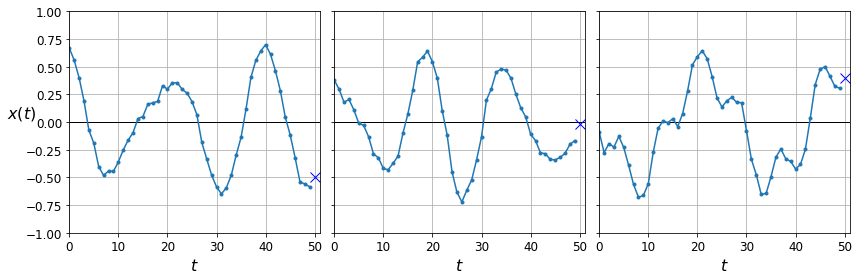

In [86]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None))
save_fig("time_series_plot")
plt.show()


### Computing Some Baselines

Naive predictions (just predict the last observed value):

In [73]:
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.020696178

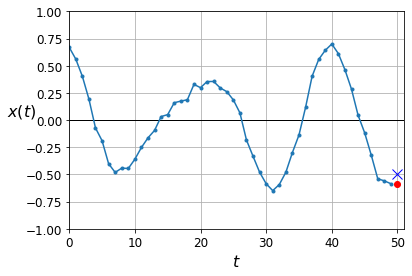

In [74]:
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

Another approach is to use a fully connected network.

Linear predictions:

In [75]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 0s 1ms/step - loss: 0.1000 - val_loss: 0.0529
Epoch 2/20
219/219 [==============================] - 0s 753us/step - loss: 0.0384 - val_loss: 0.0267
Epoch 3/20
219/219 [==============================] - 0s 670us/step - loss: 0.0207 - val_loss: 0.0160
Epoch 4/20
219/219 [==============================] - 0s 648us/step - loss: 0.0135 - val_loss: 0.0117
Epoch 5/20
219/219 [==============================] - 0s 724us/step - loss: 0.0105 - val_loss: 0.0096
Epoch 6/20
219/219 [==============================] - 0s 688us/step - loss: 0.0090 - val_loss: 0.0085
Epoch 7/20
219/219 [==============================] - 0s 660us/step - loss: 0.0081 - val_loss: 0.0077
Epoch 8/20
219/219 [==============================] - 0s 755us/step - loss: 0.0073 - val_loss: 0.0070
Epoch 9/20
219/219 [==============================] - 0s 691us/step - loss: 0.0067 - val_loss: 0.0065
Epoch 10/20
219/219 [==============================] - 0s 691us/step - loss: 0.0061 

In [77]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 617us/step - loss: 0.0042


0.00418860511854291

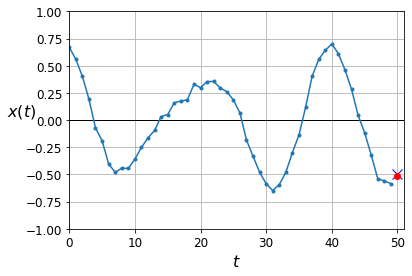

In [78]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

### Using a simple RNN

In [85]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1]) # input sequence length is not specified (None) as RNN can process any number of time steps
])

optimizer = keras.optimizers.Adam(lr=0.005)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0975 - val_loss: 0.0472
Epoch 2/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0369 - val_loss: 0.0289
Epoch 3/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0250 - val_loss: 0.0215
Epoch 4/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0194 - val_loss: 0.0175
Epoch 5/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0162 - val_loss: 0.0151
Epoch 6/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0142 - val_loss: 0.0135
Epoch 7/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0128 - val_loss: 0.0125
Epoch 8/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0120 - val_loss: 0.0118
Epoch 9/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0114 - val_loss: 0.0115
Epoch 10/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0111 - val_loss: 0.0113

In [81]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 2ms/step - loss: 0.0112


0.01121793407946825

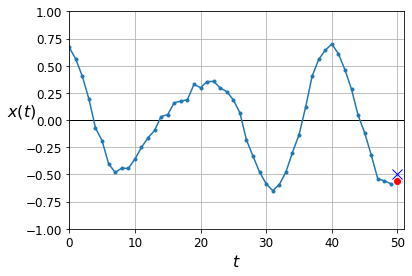

In [82]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

## Deep RNNs

In [88]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1),
])

optimizer = keras.optimizers.Adam(lr=0.005)
model.compile(loss="mse", optimizer=optimizer)

history = model.fit(X_train, y_train, epochs=20,  validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0236 - val_loss: 0.0049
Epoch 2/20
219/219 [==============================] - 3s 14ms/step - loss: 0.0043 - val_loss: 0.0039
Epoch 3/20
219/219 [==============================] - 3s 14ms/step - loss: 0.0038 - val_loss: 0.0037
Epoch 4/20
219/219 [==============================] - 3s 13ms/step - loss: 0.0036 - val_loss: 0.0040
Epoch 5/20
219/219 [==============================] - 3s 14ms/step - loss: 0.0033 - val_loss: 0.0040
Epoch 6/20
219/219 [==============================] - 3s 14ms/step - loss: 0.0035 - val_loss: 0.0036
Epoch 7/20
219/219 [==============================] - 3s 14ms/step - loss: 0.0034 - val_loss: 0.0035
Epoch 8/20
219/219 [==============================] - 3s 14ms/step - loss: 0.0032 - val_loss: 0.0030
Epoch 9/20
219/219 [==============================] - 3s 14ms/step - loss: 0.0032 - val_loss: 0.0036
Epoch 10/20
219/219 [==============================] - 3s 14ms/step - loss: 0.0033 - val_lo

In [89]:
model.evaluate(X_test, y_test)

32/32 [==============================] - 0s 4ms/step - loss: 0.0026


0.0026208984199911356

The last layer in above model is not ideal: it must have a single unit because we want to forecast a univariate time series, and this means we have a single output value per time step.

SimpleRNN uses tanh activation function by default.

For above reasons, it is preferable to replace the output layer with a Dense layer:

In [90]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1),
])

optimizer = keras.optimizers.Adam(lr=0.005)
model.compile(loss="mse", optimizer=optimizer)

history = model.fit(X_train, y_train, epochs=20,  validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0122 - val_loss: 0.0040
Epoch 2/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0034 - val_loss: 0.0040
Epoch 3/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0032 - val_loss: 0.0044
Epoch 4/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0032 - val_loss: 0.0030
Epoch 5/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0032 - val_loss: 0.0033
Epoch 6/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0033 - val_loss: 0.0032
Epoch 7/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0032 - val_loss: 0.0034
Epoch 8/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0032 - val_loss: 0.0033
Epoch 9/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0033 - val_loss: 0.0031
Epoch 10/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0031 - val_lo

Now, it converges faster and performs just as well. 

### Forecasting Several Time Steps Ahead